## Part 1 - Data Preprocessing

### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setting the working directory (change to False after running for the first time)

In [ ]:
if False:
    !mkdir "/content/drive/My Drive/tf_od_demo"
%cd "/content/drive/My Drive/tf_od_demo"

/content/drive/My Drive/tf_od_demo


### Setting up the `object_detection` library

In [ ]:
!pip install tf_slim

     |████████████████████████████████| 358kB 12.7MB/s 


In [ ]:
!pip install tf-models-official

     |████████████████████████████████| 1.1MB 12.3MB/s 
     |████████████████████████████████| 174kB 45.5MB/s 
     |████████████████████████████████| 645kB 42.4MB/s 
     |████████████████████████████████| 706kB 46.0MB/s 
     |████████████████████████████████| 37.6MB 1.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 1.2MB 43.3MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=ff0a10030ae2bba46e2af415ea1ac2d582ee70fd846a116e624bb63ebdc00d4b
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=653f7812543cd38910fd573d6786846823fa777b98c18e40fa125b9f4e93669e
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built seqeval p

In [ ]:
if True:
  
    !git clone https://github.com/tensorflow/models
    !cd models/research && protoc object_detection/protos/*.proto --python_out=.
    !cd models/research && export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim && python object_detection/builders/model_builder_test.py

fatal: destination path 'models' already exists and is not an empty directory.
2021-02-22 03:31:42.403617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Library imports

In [ ]:
import pandas as pd
import os
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

import sys
sys.path.insert(0, 'models/research')

from object_detection.utils import dataset_util

TensorFlow 1.x selected.


### A function to create one learning sample

In [ ]:
def create_tf_example(example):
  
    img_fpath = os.path.join('my_data2', example.id)
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(example.id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [example.xmin1 / float(width), example.xmin2 / float(width)] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [example.xmax1 / float(width), example.xmax2 / float(width)] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [example.ymin1 / float(height), example.ymin2 / float(height)] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [example.ymax1 / float(height), example.ymax2 / float(height)] 
    # List of string class name of bounding box (1 per box)
    classes_text = [b'Toy', b'Coffee']
    # List of integer class id of bounding box (1 per box)
    classes = [1, 2]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

### Reading the .csv file with real object coordinates (annot.csv)

In [ ]:
annot = pd.read_csv('my_data2/annot2.csv')
annot.head()

,id,xmin1,ymin1,xmax1,ymax1,xmin2,ymin2,xmax2,ymax2
0,1.jpg,507.684685,282.756757,823.684685,735.756757,121.684685,289.756757,306.684685,561.756757
1,2.jpg,351.489796,127.061224,750.489796,604.061224,123.489796,245.061224,330.489796,519.061224
2,3.jpg,341.489796,206.061224,786.489796,731.061224,135.489796,317.061224,323.489796,604.061224
3,4.jpg,342.489796,187.061224,829.489796,741.061224,102.489796,324.061224,321.489796,636.061224
4,5.jpg,75.489796,83.061224,525.489796,642.061224,567.489796,287.061224,794.489796,621.061224


### Writing the final TFRecord dataset

In [ ]:
writer = tf.python_io.TFRecordWriter('my_data2/train_data.record')

for idx, row in annot.iterrows():
    tf_example = create_tf_example(row)
    writer.write(tf_example.SerializeToString())

writer.close()

## Part 2 - Training

### Loading the pretrained model

In [ ]:
if True:
    !wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
    !tar -xzf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2021-02-22 03:33:20--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.126.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.2’

ssd_mobilenet_v1_co 100%[===================>]  73.00M  63.7MB/s    in 1.1s    

2021-02-22 03:33:22 (63.7 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.2’ saved [76541073/76541073]



### Running the fit cycle

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

In [ ]:
!pip install tf_slim

In [ ]:
!pip install lvis

In [ ]:
%%time

if True:
    # Delete the output directory
    !rm -rf my_data2/output

!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/model_main.py \
    --pipeline_config_path=my_data2/pipeline.config \
    --model_dir=my_data2/output \
    --num_train_steps=10000 \
    --alsologtostderr

W0222 03:39:08.054409 140652588582784 model_lib.py:813] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0222 03:39:08.054670 140652588582784 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0222 03:39:08.054756 140652588582784 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0222 03:39:08.054836 140652588582784 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0222 03:39:08.054905 140652588582784 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0222 03:39:08.055005 140652588582784 model_lib.py:829] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

### Freezing the final model state

In [ ]:
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=my_data2/pipeline.config \
    --trained_checkpoint_prefix=my_data2/output/model.ckpt-10000 \
    --output_directory=my_data2/output/frozen/

Instructions for updating:
Please use `layer.__call__` method instead.
W0222 08:58:35.104251 140049345693568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0222 08:58:36.800985 140049345693568 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0222 08:58:36.845757 140049345693568 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0222 08:58:36.891046 140049345693568 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

## Part 3 - Inference

In [ ]:
!pip install tf_slim

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import imageio

%tensorflow_version 1.x
import tensorflow as tf

import sys
sys.path.insert(0, 'models/research')

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Loading the class label map

In [ ]:
PATH_TO_LABELS = 'my_data2/label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Loading the frozen graph for inference

In [ ]:
PATH_TO_FROZEN_GRAPH = 'my_data2/output/frozen/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### A function for detecting objects on one image

In [ ]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[ 'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

### Running object detection

In [ ]:
image_np = imageio.imread('my_data2/test.jpg')
image_np_expanded = np.expand_dims(image_np, axis=0)

output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

### Result visualization

In [ ]:
output_dict

{'detection_boxes': array([[0.3365163 , 0.57432735, 0.99618614, 0.8686644 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.      

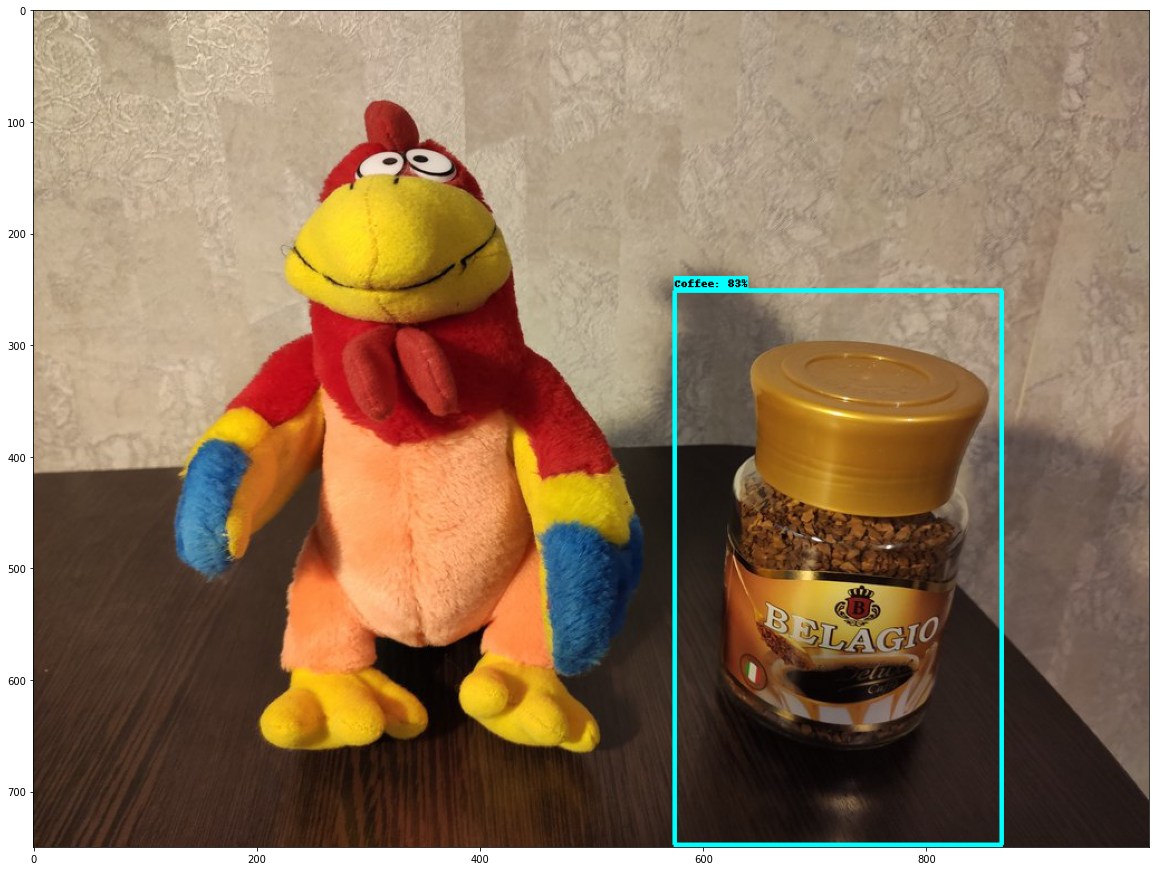

In [ ]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=4,
    min_score_thresh=0.8)

%matplotlib inline
plt.figure(figsize=(20,20))
plt.imshow(image_np)